Import Dependencies:

In [2]:
import glob
from pathlib import Path
import pandas as pd
%matplotlib inline
import hvplot.pandas
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from arch import arch_model
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error

Read CSVs files

In [3]:
# iterate over csv files of `ETH`
files_path = glob.glob('./coins/ETH/*.csv')
eth_dfs = []
for file_path in files_path:
    eth = pd.read_csv(file_path, sep=';')
    eth_dfs.append(eth)
eth = pd.concat(eth_dfs, axis='rows', join='inner')
eth['Date'] = pd.DatetimeIndex(eth['timestamp'], freq='D')
eth.set_index('Date', inplace=True)
eth.drop(columns=['timestamp'], inplace=True)
eth


,open,high,low,close,volume,marketCap
Date,,,,,,
2020-01-01 00:00:00+00:00,129.630656,132.835357,129.198285,130.802008,7.935230e+09,1.427106e+10
2020-01-02 00:00:00+00:00,130.820038,130.820038,126.954911,127.410182,8.032709e+09,1.390251e+10
2020-01-03 00:00:00+00:00,127.411261,134.554014,126.490020,134.171712,1.047685e+10,1.464213e+10
2020-01-04 00:00:00+00:00,134.168523,136.052714,133.040551,135.069371,7.430905e+09,1.474195e+10
2020-01-05 00:00:00+00:00,135.072094,139.410202,135.045629,136.276777,7.526675e+09,1.487557e+10
...,...,...,...,...,...,...
2023-05-20 00:00:00+00:00,1812.766060,1829.009603,1808.046731,1820.478001,2.951656e+09,2.189539e+11
2023-05-21 00:00:00+00:00,1820.138100,1827.922002,1799.946875,1804.531380,3.386769e+09,2.170329e+11
2023-05-22 00:00:00+00:00,1804.841868,1826.696581,1793.224036,1817.534825,4.534841e+09,2.185938e+11


In [4]:
eth.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1240 entries, 2020-01-01 00:00:00+00:00 to 2023-05-24 00:00:00+00:00
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       1240 non-null   float64
 1   high       1240 non-null   float64
 2   low        1240 non-null   float64
 3   close      1240 non-null   float64
 4   volume     1240 non-null   float64
 5   marketCap  1240 non-null   float64
dtypes: float64(6)
memory usage: 67.8 KB


## Decompose Time Series Components to Trend, Seasonality, & Noise

<Axes: title={'center': 'Ether'}, xlabel='Date'>

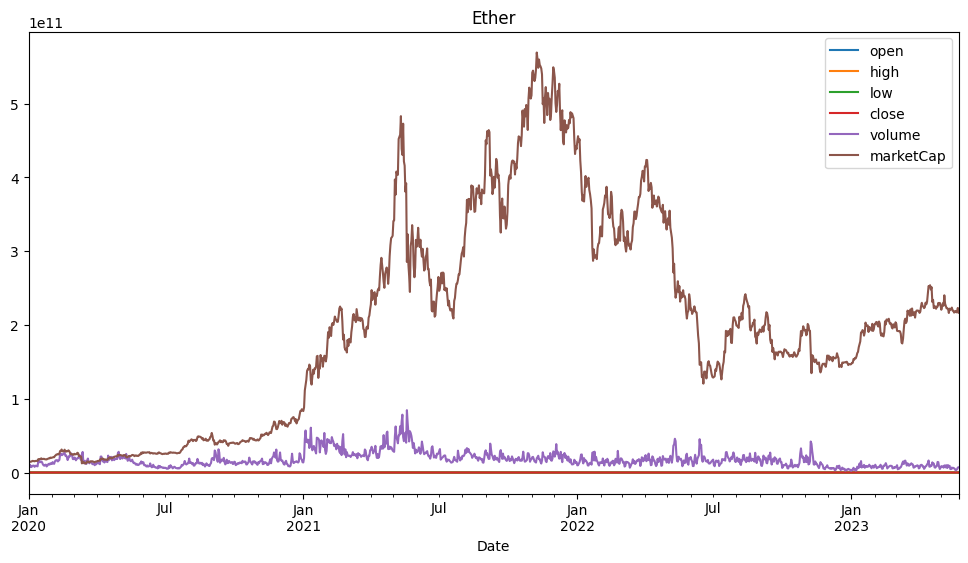

In [5]:
eth.plot(title='Ether',figsize=(12,6))

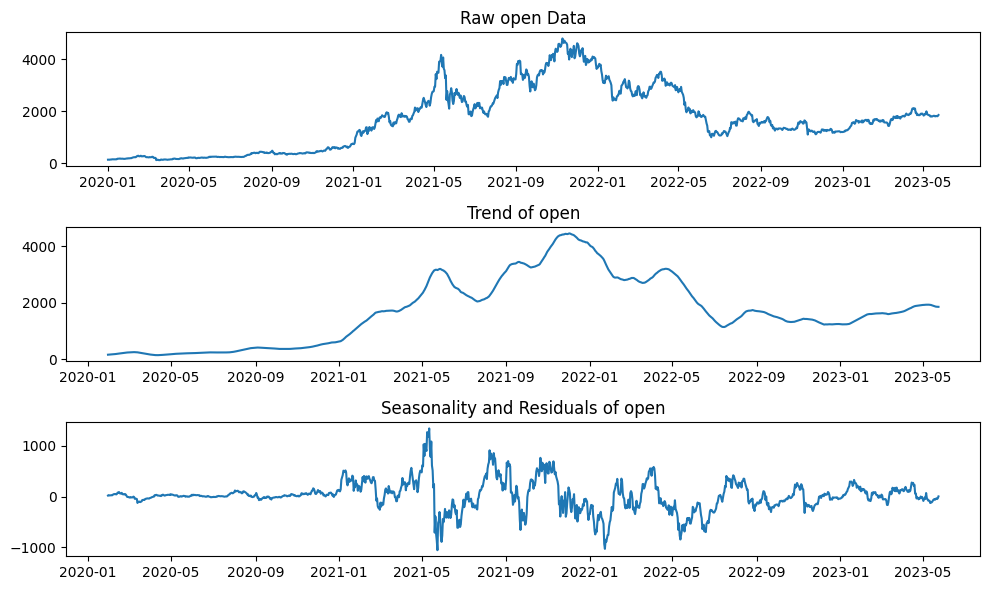

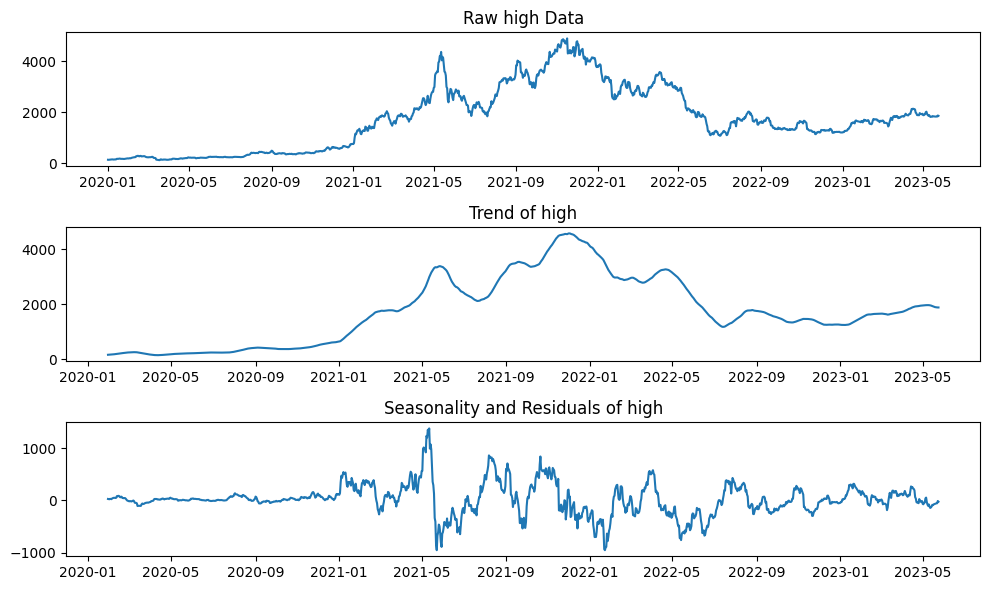

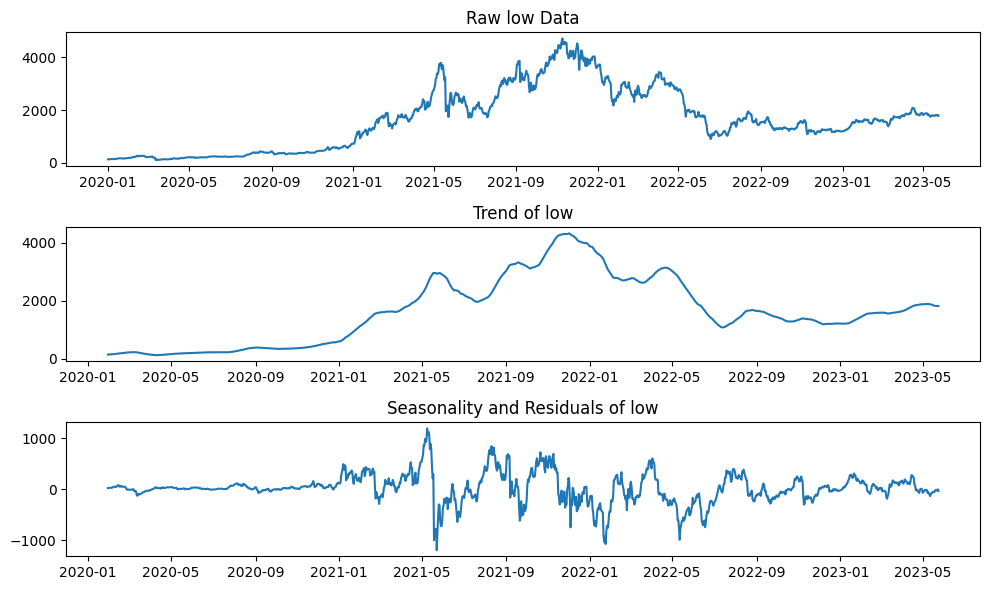

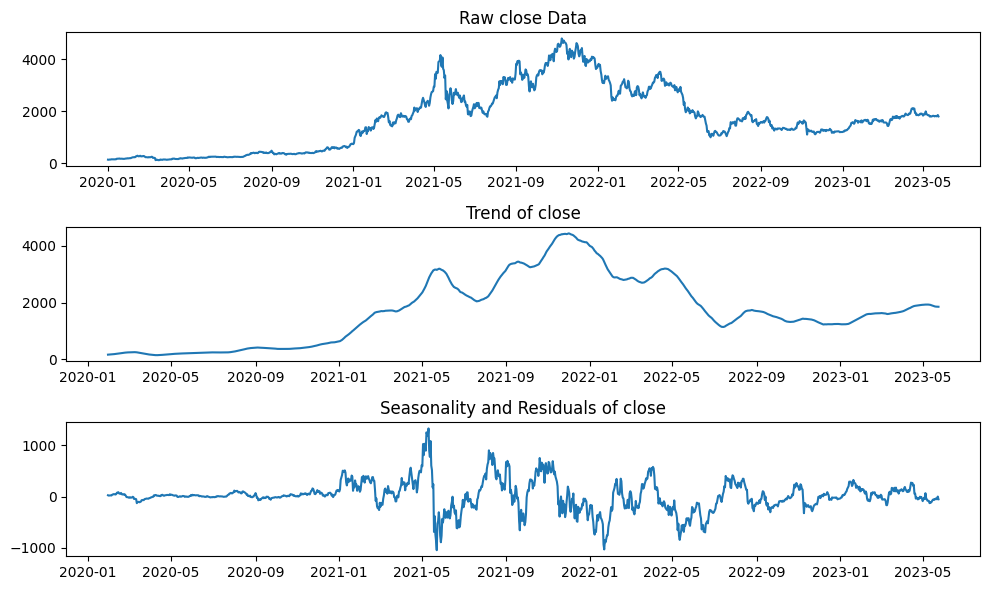

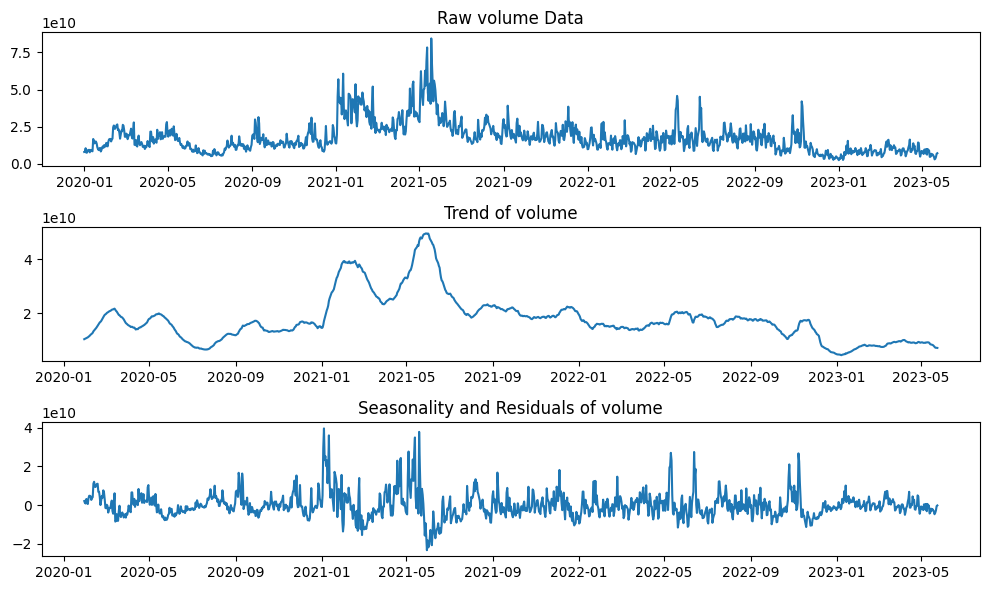

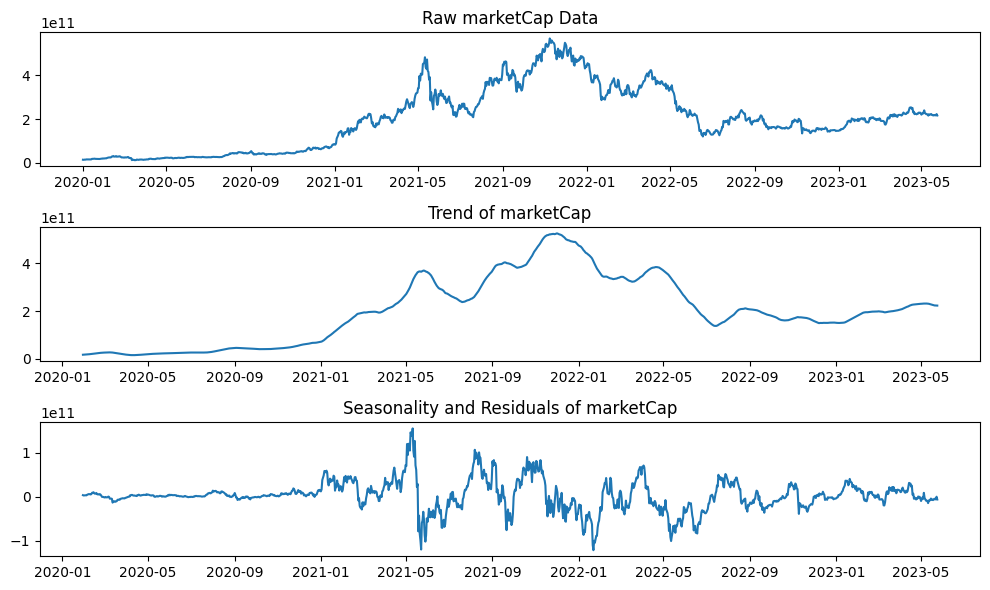

In [6]:
import matplotlib.pyplot as plt
# Define the parameters to decompose
parameters = ['open', 'high', 'low', 'close', 'volume', 'marketCap']

# Perform time series decomposition for each parameter
for parameter in parameters:
    plt.figure(figsize=(10, 6))
    plt.subplot(3, 1, 1)
    plt.plot(eth[parameter])
    plt.title(f"Raw {parameter} Data")
    
    plt.subplot(3, 1, 2)
    plt.plot(eth[parameter].rolling(window=30).mean())
    plt.title(f"Trend of {parameter}")
    
    plt.subplot(3, 1, 3)
    plt.plot(eth[parameter] - eth[parameter].rolling(window=30).mean())
    plt.title(f"Seasonality and Residuals of {parameter}")
    
    plt.tight_layout()
    plt.show()

### Check Autocorrelation & Partial Autocorrelation of different Prices

ACF which determines the q value that captures MA order
PCAF which determines the p value that captures AR order

Close Prices ACF & PCAF:

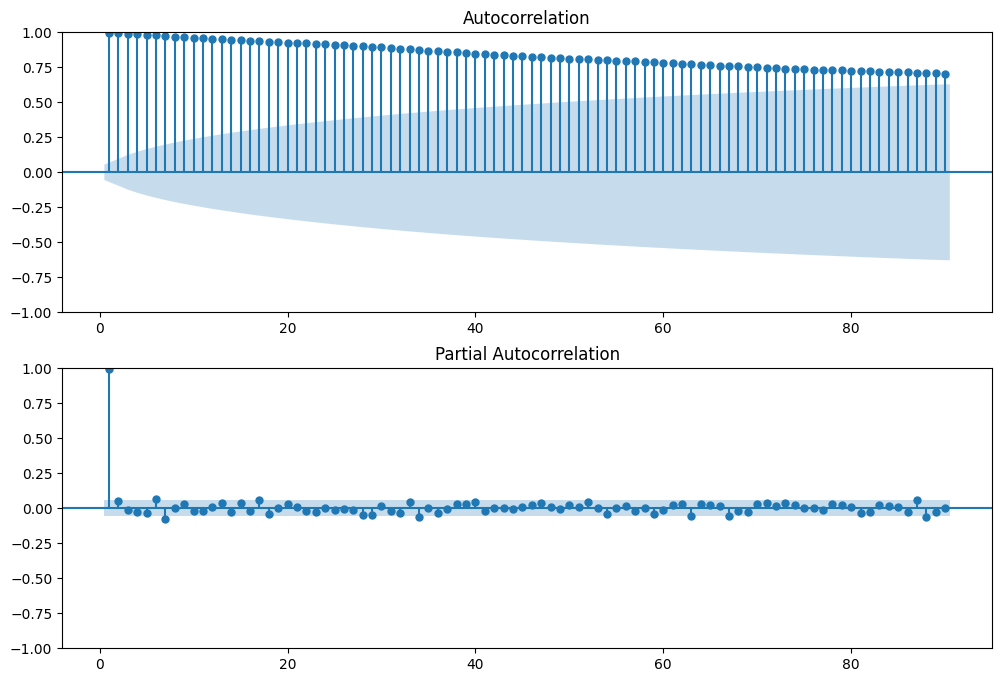

In [8]:
# Plot ACF / PCAF of `close` prices with lag of 40 => moving average (MA) order (q)
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = plot_acf(eth.close.squeeze(), lags=90, ax=ax1, zero=False)
ax2 = fig.add_subplot(212)
fig = plot_pacf(eth.close.squeeze(), lags=90, ax=ax2, zero=False)

High Prices Autocorrelation

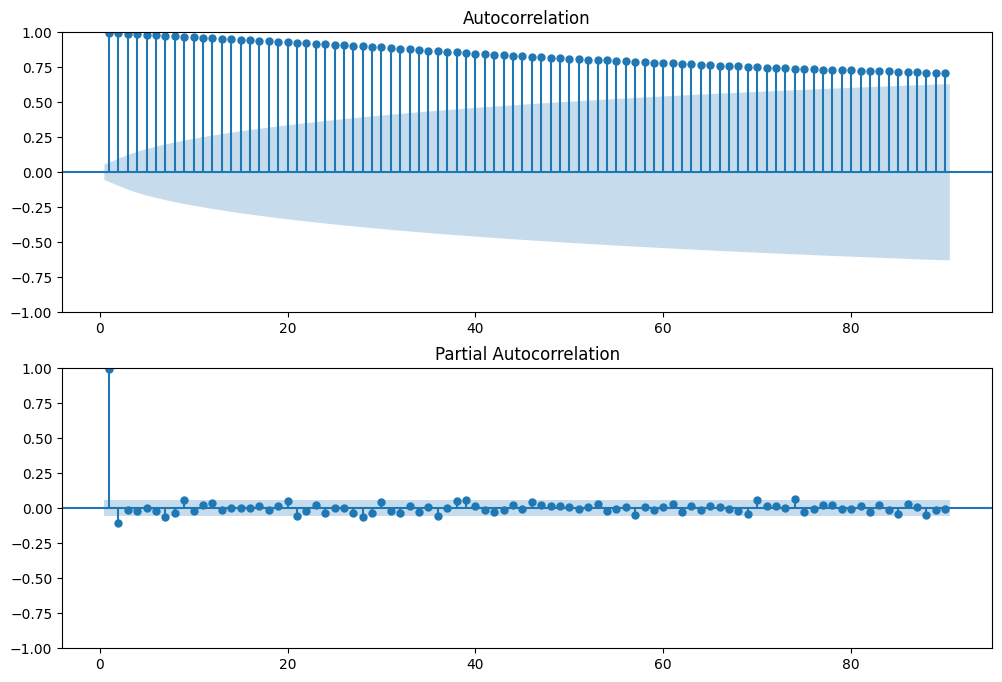

In [9]:
# Plot ACF / PCAF of `high` prices with lag of 40 => moving average (MA) order (q)
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = plot_acf(eth.high.squeeze(), lags=90, ax=ax1, zero=False)
ax2 = fig.add_subplot(212)
fig = plot_pacf(eth.high.squeeze(), lags=90, ax=ax2, zero=False)

Low Prices Autocorrelation

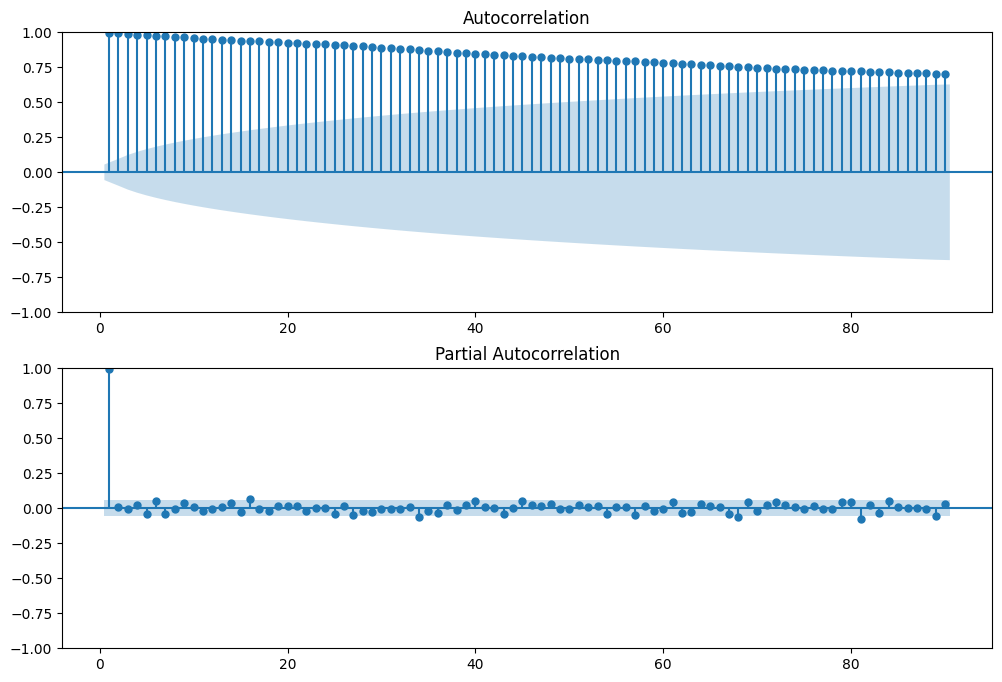

In [11]:
# Plot ACF/PCAF of `low` prices with lag of 40 => moving average (MA) order (q)
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = plot_acf(eth.low.squeeze(), lags=90, ax=ax1, zero=False)
ax2 = fig.add_subplot(212)
fig = plot_pacf(eth.low.squeeze(), lags=90, ax=ax2, zero=False)

    Observation:
        it appears that there is strong autocorrelation in the ACF suggesting a non-seasonal AR component. 
        The lack of significant correlation in the PACF beyond the first lag indicates that an MA component may not be necessary.

### Check if Data is Stationary using Augmented Dickey-Fuller 

In [12]:
# Apply Augmented Dickey-Fuller test to check stationary
adfuller(eth.close)

(-1.7393044606153438,
 0.41098381231839054,
 6,
 1233,
 {'1%': -3.4356646522289815,
  '5%': -2.863886926389418,
  '10%': -2.568019536239491},
 14564.163628486443)

    Observation:
        with p-value of 0.4 it indicates that data are non-stationary

In [13]:
adfuller(eth.high)

(-1.7111237820700707,
 0.4253904752400304,
 8,
 1231,
 {'1%': -3.435673305025808,
  '5%': -2.863890744031555,
  '10%': -2.56802156936202},
 14069.267053665446)

    Observation:
        with p-value of 0.4 it indicates that data are non-stationar

In [14]:
adfuller(eth.low)

(-1.765374153679963,
 0.3977828480048589,
 0,
 1239,
 {'1%': -3.435638861796935,
  '5%': -2.863875547501718,
  '10%': -2.5680134763122906},
 14611.664331708758)

    Observation:
        with p-value of 0.4 it indicates that data are non-stationary

# First Model: GARCH Model to Analyze and Predict Risk

In [135]:
# preprocess data to eliminate unnecessary columns
volatility_df = eth.copy()
columns_to_drop = ['open', 'volume', 'marketCap']
volatility_df.drop(columns_to_drop, axis=1, inplace=True)

volatility_df

,high,low,close
Date,,,
2020-01-01 00:00:00+00:00,132.835357,129.198285,130.802008
2020-01-02 00:00:00+00:00,130.820038,126.954911,127.410182
2020-01-03 00:00:00+00:00,134.554014,126.490020,134.171712
2020-01-04 00:00:00+00:00,136.052714,133.040551,135.069371
2020-01-05 00:00:00+00:00,139.410202,135.045629,136.276777
...,...,...,...
2023-05-20 00:00:00+00:00,1829.009603,1808.046731,1820.478001
2023-05-21 00:00:00+00:00,1827.922002,1799.946875,1804.531380
2023-05-22 00:00:00+00:00,1826.696581,1793.224036,1817.534825


In [136]:
# convert non stationary columns to stationary
returns = volatility_df[['high', 'low', 'close']].diff().dropna()
returns

,high,low,close
Date,,,
2020-01-02 00:00:00+00:00,-2.015319,-2.243374,-3.391826
2020-01-03 00:00:00+00:00,3.733976,-0.464891,6.761530
2020-01-04 00:00:00+00:00,1.498700,6.550531,0.897659
2020-01-05 00:00:00+00:00,3.357488,2.005078,1.207405
2020-01-06 00:00:00+00:00,4.917980,1.034003,8.027377
...,...,...,...
2023-05-20 00:00:00+00:00,2.815406,10.612280,7.888492
2023-05-21 00:00:00+00:00,-1.087601,-8.099856,-15.946621
2023-05-22 00:00:00+00:00,-1.225421,-6.722839,13.003445


In [137]:
returns.isnull().sum()

high     0
low      0
close    0
dtype: int64

In [138]:
returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1239 entries, 2020-01-02 00:00:00+00:00 to 2023-05-24 00:00:00+00:00
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   high    1239 non-null   float64
 1   low     1239 non-null   float64
 2   close   1239 non-null   float64
dtypes: float64(3)
memory usage: 38.7 KB


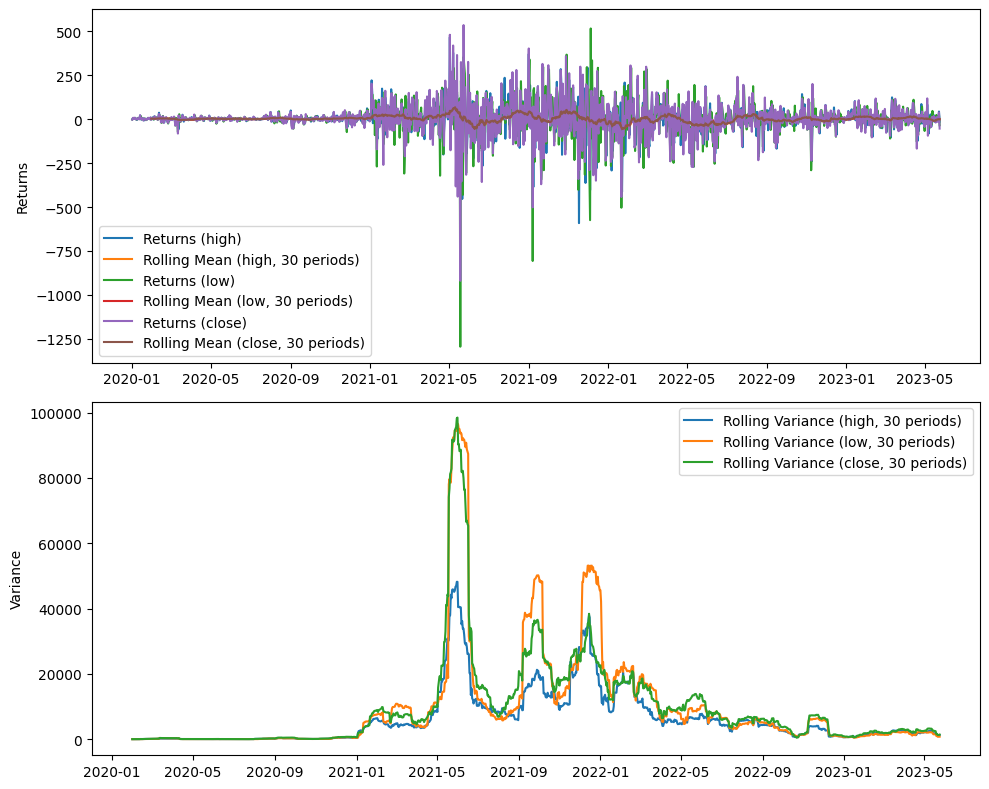

In [139]:
window_size = 30  

# Calculate rolling mean and variance for each column
rolling_mean = returns.rolling(window=window_size).mean()
rolling_variance = returns.rolling(window=window_size).var()

# Plot the mean and variance over time for each column
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

for column in returns.columns:
    ax[0].plot(returns.index, returns[column], label=f'Returns ({column})')
    ax[0].plot(returns.index, rolling_mean[column], label=f'Rolling Mean ({column}, {window_size} periods)')

    ax[1].plot(returns.index, rolling_variance[column], label=f'Rolling Variance ({column}, {window_size} periods)')

ax[0].set_ylabel('Returns')
ax[0].legend()

ax[1].set_ylabel('Variance')
ax[1].legend()

plt.tight_layout()
plt.show()

In [140]:
model_high = arch_model(returns['high'], mean='zero', vol='GARCH', p=2, q=10)
volatility_high = model_high.fit(disp='off')
volatility_high

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   high   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -6503.08
Distribution:                  Normal   AIC:                           13032.2
Method:            Maximum Likelihood   BIC:                           13098.8
                                        No. Observations:                 1239
Date:                Wed, May 31 2023   Df Residuals:                     1239
Time:                        17:45:35   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          7.2582      5.102      1.423      0.155   [ -2.74

In [141]:
model_close = arch_model(returns['close'], mean='zero', vol='GARCH', p=1, q=10)
volatility_close = model_close.fit(disp='off')
volatility_close

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                  close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -6686.62
Distribution:                  Normal   AIC:                           13397.2
Method:            Maximum Likelihood   BIC:                           13458.7
                                        No. Observations:                 1239
Date:                Wed, May 31 2023   Df Residuals:                     1239
Time:                        17:45:37   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          4.9650      2.691      1.845  6.499e-02   [ -0.30

In [142]:
model_low = arch_model(returns['low'], mean='zero', vol='GARCH', p=1, q=10)
volatility_low = model_low.fit(disp='off')
volatility_low

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                    low   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -6603.71
Distribution:                  Normal   AIC:                           13231.4
Method:            Maximum Likelihood   BIC:                           13292.9
                                        No. Observations:                 1239
Date:                Wed, May 31 2023   Df Residuals:                     1239
Time:                        17:45:40   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          3.1158      2.505      1.244      0.214   [ -1.79

## Forecasting GARCH till end of 2023

In [169]:
# Set the forecast horizon in days
forecast_horizon = 222

# Get the last date in your data
last_date = returns.index[-1].date()

# CLOSE VOLATILITY
# Generate a forecast for the specified number of days
forecast_close = volatility_close.forecast(start=last_date, horizon=forecast_horizon, reindex=True)

# Access the forecasted volatility values
close_values = forecast_close.variance.iloc[-1].values

# Calculate the forecasted volatility by taking the square root of the variance
forecasted_close_vol = np.sqrt(close_values)

# HIGH VOLATILITY
# Generate a forecast for the specified number of days
forecast_high= volatility_high.forecast(start=last_date, horizon=forecast_horizon, reindex=True)

# Access the forecasted volatility values
high_values = forecast_high.variance.iloc[-1].values

# Calculate the forecasted volatility by taking the square root of the variance
forecasted_high_vol = np.sqrt(high_values)

# LOW VOLATILITY
# Generate a forecast for the specified number of days
forecast_low = volatility_low.forecast(start=last_date, horizon=forecast_horizon, reindex=True)

# Access the forecasted volatility values
low_values = forecast_low.variance.iloc[-1].values

# Calculate the forecasted volatility by taking the square root of the variance
forecasted_low_vol = np.sqrt(low_values)

# Print the forecasted volatility values
# print(forecast_volatility)

# Create a DateTimeIndex for the forecasted dates
forecast_dates = pd.date_range(start=returns.index[-1], periods=forecast_horizon + 1, freq='D')[1:]

# Create the predicted_Volatility DataFrame
predicted_Volatility = pd.DataFrame(
    {
    'high': forecasted_high_vol,
    'low': forecasted_low_vol,
    'close': forecasted_close_vol
    },
    index=forecast_dates
)

# Convert the index to datetime format
predicted_Volatility.index = predicted_Volatility.index.strftime('%m-%d-%Y')

predicted_Volatility


,high,low,close
05-25-2023,33.114580,27.404928,36.060741
05-26-2023,33.208185,27.743932,35.280844
05-27-2023,34.080576,27.956796,34.841067
05-28-2023,34.281512,28.069244,35.128481
05-29-2023,34.331344,28.120324,35.226416
...,...,...,...
12-28-2023,39.337042,35.125299,44.353596
12-29-2023,39.359869,35.156146,44.392606
12-30-2023,39.382682,35.186967,44.431582
12-31-2023,39.405482,35.217760,44.470524


In [170]:
predicted_Volatility.isnull().sum()

high     0
low      0
close    0
dtype: int64

In [171]:
predicted_Volatility.info()

<class 'pandas.core.frame.DataFrame'>
Index: 222 entries, 05-25-2023 to 01-01-2024
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   high    222 non-null    float64
 1   low     222 non-null    float64
 2   close   222 non-null    float64
dtypes: float64(3)
memory usage: 6.9+ KB


In [172]:
# Save predicted prices DataFrame to JSON
predicted_Volatility.to_json('./coins/ETH/predictions/predicted_Volatility.json')

# Save predicted prices DataFrame to CSV
predicted_Volatility.to_csv('./coins/ETH/predictions/predicted_Volatility.csv')

# Second Model: Long Short-Term Memory 
# Recurrent Neural Networks to Predict Prices

In [173]:
# fix random seed for reproducibility
tf.random.set_seed(7)

In [174]:
# save a copy from dataframe & drop unused columns in model
df = eth.copy()
df.drop(columns=['open', 'volume', 'marketCap'], inplace=True)
df

,high,low,close
Date,,,
2020-01-01 00:00:00+00:00,132.835357,129.198285,130.802008
2020-01-02 00:00:00+00:00,130.820038,126.954911,127.410182
2020-01-03 00:00:00+00:00,134.554014,126.490020,134.171712
2020-01-04 00:00:00+00:00,136.052714,133.040551,135.069371
2020-01-05 00:00:00+00:00,139.410202,135.045629,136.276777
...,...,...,...
2023-05-20 00:00:00+00:00,1829.009603,1808.046731,1820.478001
2023-05-21 00:00:00+00:00,1827.922002,1799.946875,1804.531380
2023-05-22 00:00:00+00:00,1826.696581,1793.224036,1817.534825


In [175]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1240 entries, 2020-01-01 00:00:00+00:00 to 2023-05-24 00:00:00+00:00
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   high    1240 non-null   float64
 1   low     1240 non-null   float64
 2   close   1240 non-null   float64
dtypes: float64(3)
memory usage: 38.8 KB


In [176]:
# `window_data`: function to accept col. no. for features (X) & target (y)
# it chunks the data up with a rolling window of Xt - window to predict Xt+1
# `df`: time series DataFrame
# `window`: window size of days used in prediction
def window_data(df, window, feature_col_numbers, target_col_numbers):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_numbers]
        targets = df.iloc[(i + window), target_col_numbers]
        X.append(features)
        y.append(targets)
    return np.array(X), np.array(y)

In [177]:
# Creating the features (X) and targets (y) data using the window_data() function.
# window size of 868 previous days of high, low, close prices
window_size = 24
# high, low, close columns
feature_columns = [0, 1, 2]
target_columns = [0, 1, 2]
X, y = window_data(df, window_size, feature_columns, target_columns)

In [178]:
# splitting data bet 70%  train and 30% test of each column
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

850
850
365
365


In [179]:
# scale data before training the model with MinMaxScaler to scale values between 0 & 1
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale the training data
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, len(feature_columns)))
y_train_scaled = scaler.fit_transform(y_train.reshape(-1, len(target_columns)))

# Scale the test data
X_test_scaled = scaler.transform(X_test.reshape(-1, len(feature_columns)))
y_test_scaled = scaler.transform(y_test.reshape(-1, len(target_columns)))

In [180]:
# Reshape the training data
# X_train_reshaped: (sample, time steps, features)=(850, 24, 3)
X_train_reshaped = X_train_scaled.reshape((X_train.shape[0], window_size, len(feature_columns)))
# y_train_reshaped:(850,3)
y_train_reshaped = y_train_scaled.reshape((y_train.shape[0], len(target_columns)))

# Reshape the test data
# X_test_reshaped: (sample, time steps, features)=(850, 24, 3)
X_test_reshaped = X_test_scaled.reshape((X_test.shape[0], window_size, len(feature_columns)))
# y_test_reshaped:(850,3)
y_test_reshaped = y_test_scaled.reshape((y_test.shape[0], len(target_columns)))

In [181]:
# Define the LSTM RNN model
model = Sequential()
#Input layer
model.add(LSTM(units=24, return_sequences=True, input_shape=(window_size, len(feature_columns))))
model.add(Dropout(0.2))
# layer 2
model.add(LSTM(units=24, return_sequences=True))
model.add(Dropout(0.2))
# layer 3
model.add(LSTM(units=24, return_sequences=True))
model.add(Dropout(0.2))
# layer 4
model.add(LSTM(units=24))
model.add(Dropout(0.2))
# Output layer
model.add(Dense(len(target_columns)))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train_reshaped, y_train_reshaped, epochs=100, batch_size=32, verbose=2)

# Make predictions on the training set
predicted_train = model.predict(X_train_reshaped)
# Calculate Mean Squared Error of train set
mse_train = mean_squared_error(y_train_reshaped, predicted_train)
print("MSE for train set:", mse_train)

# Make predictions on the test set
predicted_test = model.predict(X_test_reshaped)
# Calculate Mean Squared Error of test set
mse_test = mean_squared_error(y_test_reshaped, predicted_test)
print("MSE for test set:", mse_test)

Epoch 1/100
27/27 - 8s - loss: 0.0752 - 8s/epoch - 300ms/step
Epoch 2/100
27/27 - 1s - loss: 0.0163 - 681ms/epoch - 25ms/step
Epoch 3/100
27/27 - 1s - loss: 0.0136 - 609ms/epoch - 23ms/step
Epoch 4/100
27/27 - 1s - loss: 0.0122 - 619ms/epoch - 23ms/step
Epoch 5/100
27/27 - 1s - loss: 0.0120 - 581ms/epoch - 22ms/step
Epoch 6/100
27/27 - 1s - loss: 0.0130 - 599ms/epoch - 22ms/step
Epoch 7/100
27/27 - 1s - loss: 0.0125 - 562ms/epoch - 21ms/step
Epoch 8/100
27/27 - 1s - loss: 0.0113 - 605ms/epoch - 22ms/step
Epoch 9/100
27/27 - 1s - loss: 0.0096 - 617ms/epoch - 23ms/step
Epoch 10/100
27/27 - 1s - loss: 0.0101 - 613ms/epoch - 23ms/step
Epoch 11/100
27/27 - 1s - loss: 0.0096 - 641ms/epoch - 24ms/step
Epoch 12/100
27/27 - 1s - loss: 0.0084 - 636ms/epoch - 24ms/step
Epoch 13/100
27/27 - 1s - loss: 0.0099 - 589ms/epoch - 22ms/step
Epoch 14/100
27/27 - 1s - loss: 0.0079 - 665ms/epoch - 25ms/step
Epoch 15/100
27/27 - 1s - loss: 0.0077 - 683ms/epoch - 25ms/step
Epoch 16/100
27/27 - 1s - loss: 0.00

In [182]:
# Summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 24)            2688      
                                                                 
 dropout (Dropout)           (None, 24, 24)            0         
                                                                 
 lstm_1 (LSTM)               (None, 24, 24)            4704      
                                                                 
 dropout_1 (Dropout)         (None, 24, 24)            0         
                                                                 
 lstm_2 (LSTM)               (None, 24, 24)            4704      
                                                                 
 dropout_2 (Dropout)         (None, 24, 24)            0         
                                                                 
 lstm_3 (LSTM)               (None, 24)                4

In [183]:
# Evaluate the model
loss = model.evaluate(X_test_reshaped, y_test_reshaped)
loss

12/12 [==============================] - 2s 7ms/step - loss: 5.0870e-04


0.0005087049212306738

In [184]:
# Inverse scaling to obtain the original prices
predicted_train_inv = scaler.inverse_transform(predicted_train)
predicted_test_inv = scaler.inverse_transform(predicted_test)
predicted_test_inv

array([[2054.615 , 1899.9834, 1997.1564],
       [2048.4604, 1893.8207, 1990.9163],
       [2041.2424, 1886.8092, 1983.7712],
       ...,
       [1877.3892, 1735.3484, 1825.4976],
       [1879.9663, 1737.531 , 1827.8108],
       [1880.9861, 1738.249 , 1828.6412]], dtype=float32)

In [185]:
# Inverse scaling to obtain the original prices
y_test_inv = scaler.inverse_transform(y_test_reshaped)

# Create a new DataFrame using the predicted and real values
predicted_df = pd.DataFrame({
    "Predicted High": predicted_test_inv[:, 0],
    "Real High": df["high"][-len(y_test_inv):].values,
    "Predicted Low": predicted_test_inv[:, 1],
    "Real Low": df["low"][-len(y_test_inv):].values,
    "Predicted Close": predicted_test_inv[:, 2],
    "Real Close": df["close"][-len(y_test_inv):].values
}, index=df.index[-len(y_test_inv):])

predicted_df.tail()


,Predicted High,Real High,Predicted Low,Real Low,Predicted Close,Real Close
Date,,,,,,
2023-05-20 00:00:00+00:00,1868.401489,1829.009603,1727.233643,1808.046731,1817.164307,1820.478001
2023-05-21 00:00:00+00:00,1873.405029,1827.922002,1731.816406,1799.946875,1821.839355,1804.531380
2023-05-22 00:00:00+00:00,1877.389160,1826.696581,1735.348389,1793.224036,1825.497559,1817.534825
2023-05-23 00:00:00+00:00,1879.966309,1869.344019,1737.531006,1816.287938,1827.810791,1854.380631
2023-05-24 00:00:00+00:00,1880.986084,1854.299709,1738.249023,1780.925500,1828.641235,1800.100017


In [186]:
predicted_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2022-05-25 00:00:00+00:00 to 2023-05-24 00:00:00+00:00
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Predicted High   365 non-null    float32
 1   Real High        365 non-null    float64
 2   Predicted Low    365 non-null    float32
 3   Real Low         365 non-null    float64
 4   Predicted Close  365 non-null    float32
 5   Real Close       365 non-null    float64
dtypes: float32(3), float64(3)
memory usage: 15.7 KB


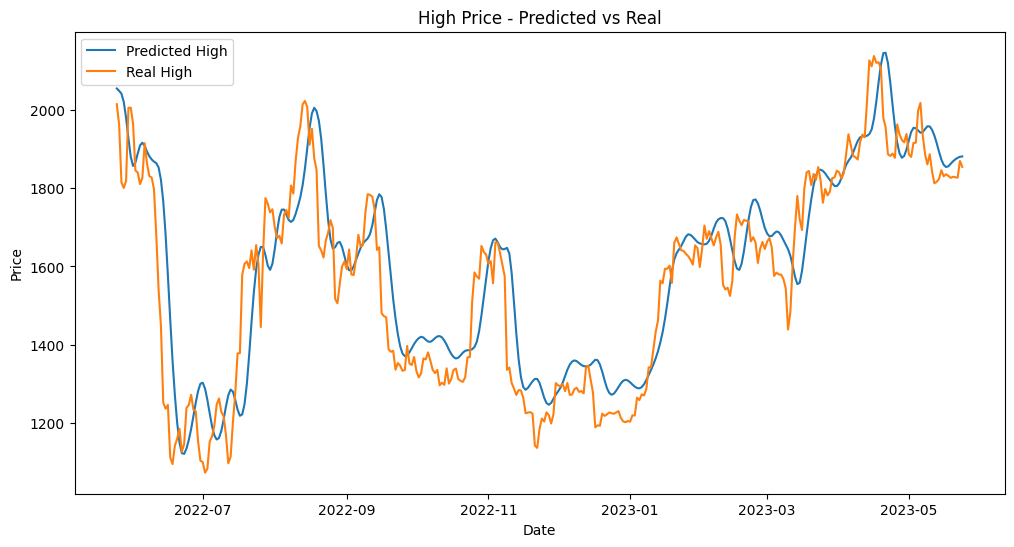

In [187]:
# Plotting the predicted and real values for High
plt.figure(figsize=(12, 6))
plt.plot(predicted_df.index, predicted_df["Predicted High"], label="Predicted High")
plt.plot(predicted_df.index, predicted_df["Real High"], label="Real High")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("High Price - Predicted vs Real")
plt.legend()
plt.show()

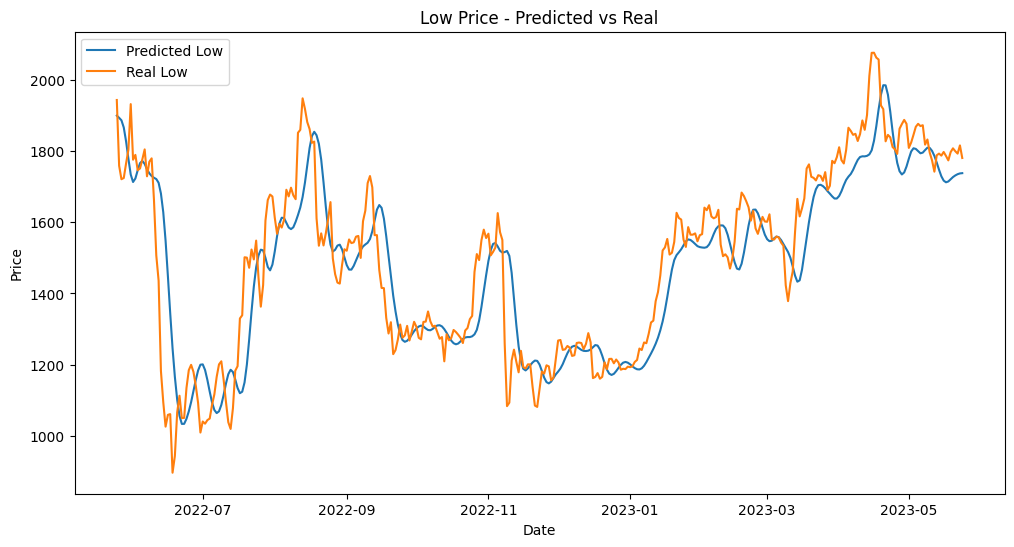

In [188]:
# Plotting the predicted and real values for Low
plt.figure(figsize=(12, 6))
plt.plot(predicted_df.index, predicted_df["Predicted Low"], label="Predicted Low")
plt.plot(predicted_df.index, predicted_df["Real Low"], label="Real Low")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Low Price - Predicted vs Real")
plt.legend()
plt.show()

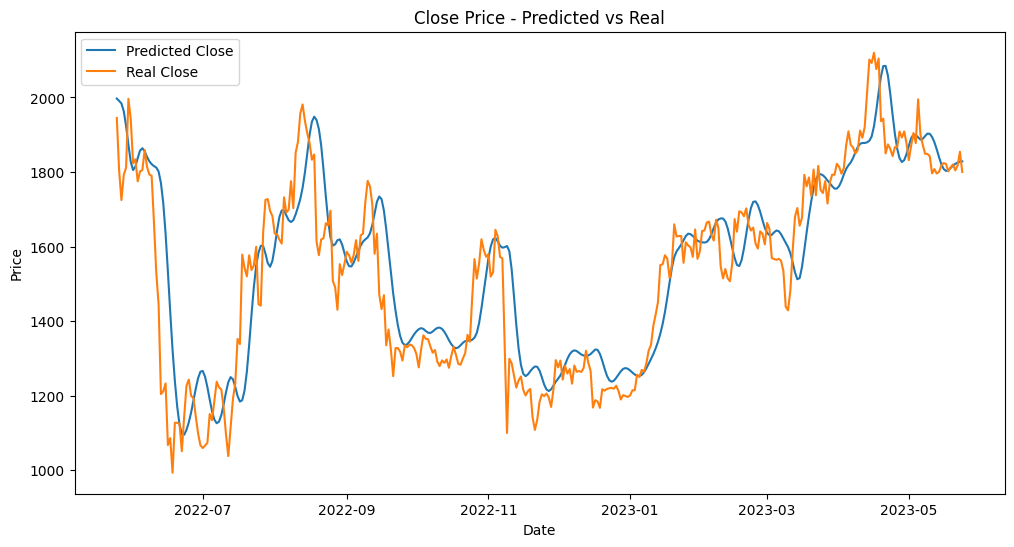

In [189]:
# Plotting the predicted and real values for Close
plt.figure(figsize=(12, 6))
plt.plot(predicted_df.index, predicted_df["Predicted Close"], label="Predicted Close")
plt.plot(predicted_df.index, predicted_df["Real Close"], label="Real Close")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Close Price - Predicted vs Real")
plt.legend()
plt.show()

## Predict Prices till end of 2023


In [191]:
# Define the number of future time steps to predict
num_steps = 222
num_features = 3  # Number of features (high, low, close)

# Create an empty DataFrame to store the predicted prices
predicted_prices_df = pd.DataFrame(columns=["Predicted High", "Predicted Low", "Predicted Close"])

# Get the last date from the original DataFrame
last_date = df.index[-1]

# Iterate for the desired number of time steps
for _ in range(num_steps):
    # Prepare the input data for prediction
    input_data = df[-window_size:].values
    input_data_scaled = scaler.transform(input_data)
    input_data_reshaped = input_data_scaled.reshape((1, window_size, num_features))

    # Make the prediction
    predicted_values_scaled = model.predict(input_data_reshaped)
    predicted_values = scaler.inverse_transform(predicted_values_scaled)

    # Create a DataFrame to store the predicted values for the current time step
    predicted_step_df = pd.DataFrame(
        predicted_values.reshape(1, -1),
        columns=["Predicted High", "Predicted Low", "Predicted Close"]
    )

    # Get the next date by adding one day to the last date
    next_date = last_date + pd.DateOffset(days=1)

    # Set the index of the predicted step DataFrame to the next date
    predicted_step_df.index = [next_date.strftime('%m-%d-%Y')]

    # Concatenate the predicted step DataFrame with the main DataFrame
    predicted_prices_df = pd.concat([predicted_prices_df, predicted_step_df])

    # Update the last date
    last_date = next_date

predicted_prices_df

1/1 [==============================] - 0s 104ms/step


,Predicted High,Predicted Low,Predicted Close
05-25-2023,1884.509155,1741.301392,1831.910889
05-26-2023,1884.509155,1741.301392,1831.910889
05-27-2023,1884.509155,1741.301392,1831.910889
05-28-2023,1884.509155,1741.301392,1831.910889
05-29-2023,1884.509155,1741.301392,1831.910889
...,...,...,...
12-28-2023,1884.509155,1741.301392,1831.910889
12-29-2023,1884.509155,1741.301392,1831.910889
12-30-2023,1884.509155,1741.301392,1831.910889
12-31-2023,1884.509155,1741.301392,1831.910889


In [192]:
# Reset the index and assign a name to the index column
predicted_prices_df.reset_index(inplace=True)
predicted_prices_df.rename(columns={'index': 'Date'}, inplace=True)
predicted_prices_df.set_index('Date', inplace=True)

# Display the DataFrame
predicted_prices_df


,Predicted High,Predicted Low,Predicted Close
Date,,,
05-25-2023,1884.509155,1741.301392,1831.910889
05-26-2023,1884.509155,1741.301392,1831.910889
05-27-2023,1884.509155,1741.301392,1831.910889
05-28-2023,1884.509155,1741.301392,1831.910889
05-29-2023,1884.509155,1741.301392,1831.910889
...,...,...,...
12-28-2023,1884.509155,1741.301392,1831.910889
12-29-2023,1884.509155,1741.301392,1831.910889
12-30-2023,1884.509155,1741.301392,1831.910889


In [193]:
predicted_prices_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 222 entries, 05-25-2023 to 01-01-2024
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Predicted High   222 non-null    float32
 1   Predicted Low    222 non-null    float32
 2   Predicted Close  222 non-null    float32
dtypes: float32(3)
memory usage: 4.3+ KB


In [194]:
predicted_prices_df.isnull().sum()

Predicted High     0
Predicted Low      0
Predicted Close    0
dtype: int64

In [181]:
# Save predicted prices DataFrame to JSON
predicted_prices_df.to_json('./coins/ETH/predictions/predicted_prices.json')

# Save predicted prices DataFrame to CSV
predicted_prices_df.to_csv('./coins/ETH/predictions/predicted_prices.csv')